In [47]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import corner
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer


plt.rc('text', usetex=True)  # Abilita l'uso di LaTeX in tutte le stringhe di testo
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [34]:
df = pd.read_csv('../solutions/galaxyquasar.csv')

In [35]:
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [36]:
ug = np.array(df['u']-df['g'])
gr = np.array(df['g']-df['r'])
ri = np.array(df['r']-df['i'])
iz = np.array(df['i']-df['z'])

labels = np.where(df['class'] == 'QSO', 1, 0)

In [37]:
X = np.column_stack((ug, gr, ri, iz))
X_train, X_test, lab_train, lab_test = train_test_split(X, labels, test_size=0.3, random_state=7)

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


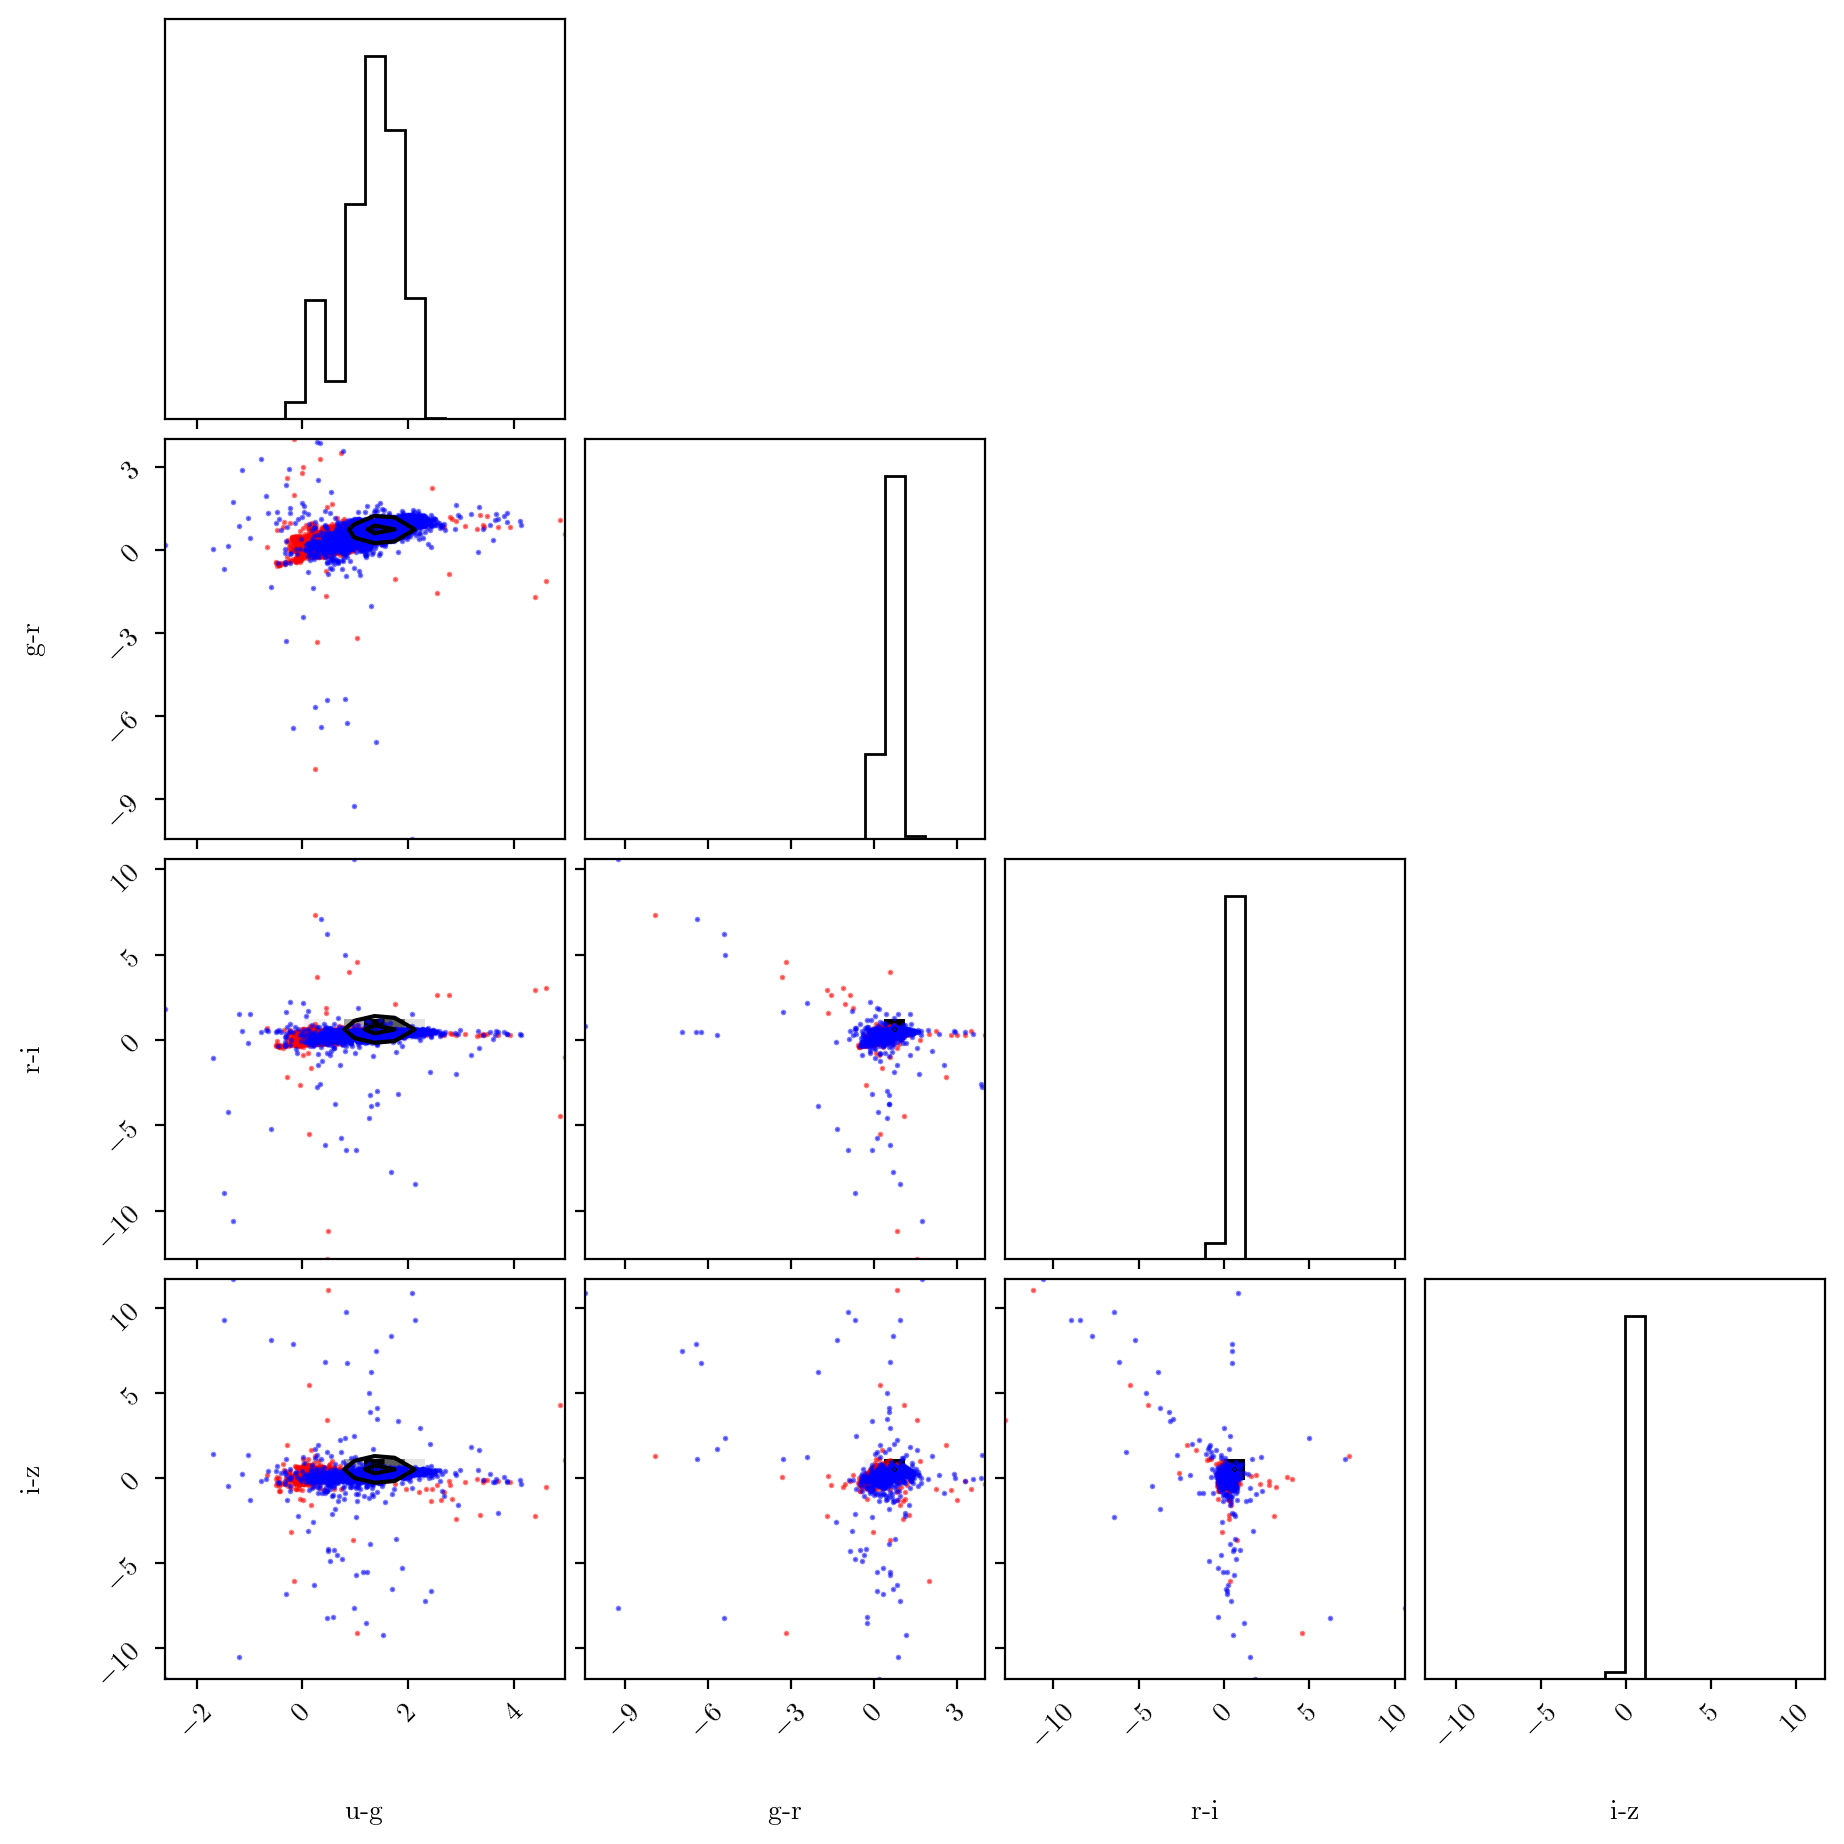

In [38]:
figure = corner.corner(X, labels=["u-g", "g-r", "r-i", "i-z"], plot_datapoints=False)

axes = np.array(figure.axes).reshape((4, 4))

for i in range(4):
    for j in range(i):
        ax = axes[i, j]
        ax.scatter(X[labels == 1, j], X[labels == 1, i], color="red", s=1, label="QSO", alpha=0.5)
        ax.scatter(X[labels == 0, j], X[labels == 0, i], color="blue", s=1, label="Galaxy", alpha=0.5)

plt.show()

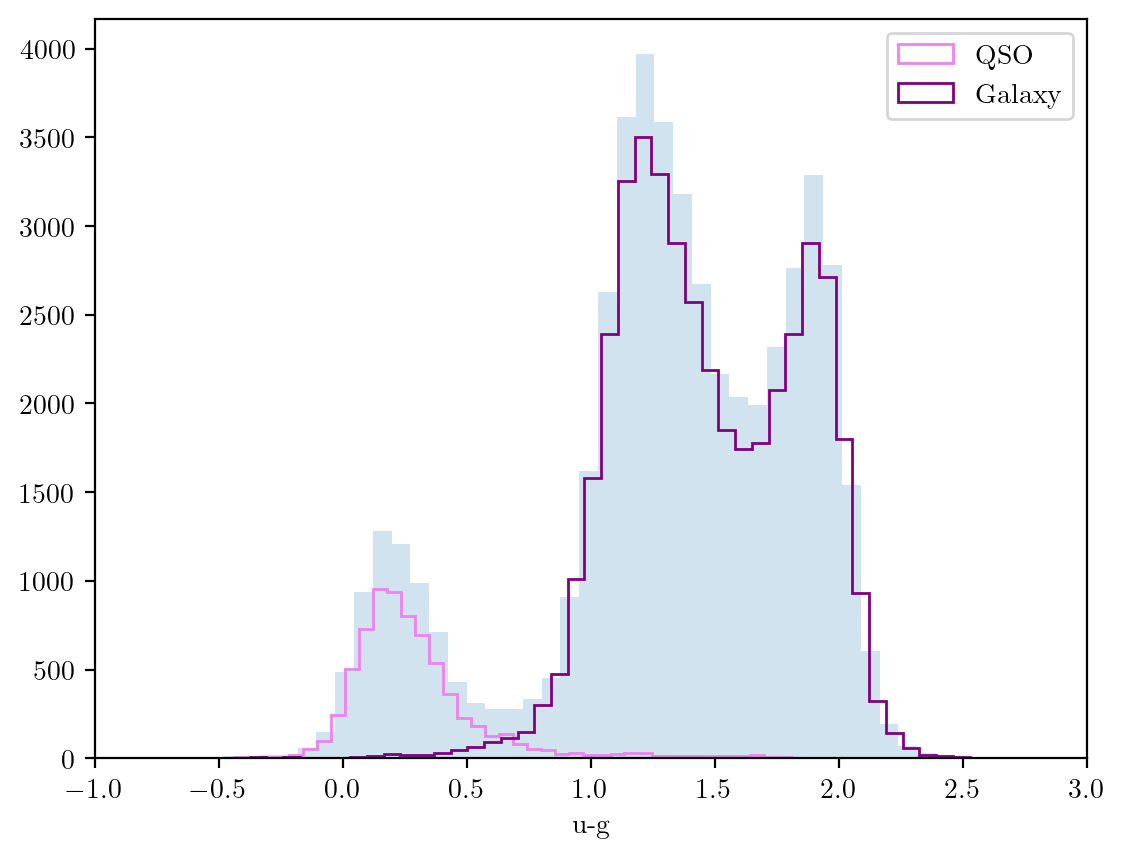

In [39]:
#histogram of u-g
plt.hist(ug, bins=100, alpha=0.2)
plt.hist(ug[labels==1], histtype='step', bins=100, label='QSO', color='violet')
plt.hist(ug[labels==0], histtype='step', bins=100, label='Galaxy', color='purple')
plt.xlim(-1,3)
plt.xlabel('u-g')
plt.legend()
plt.show()

### Gaussian Naive Bayes

Gaussian Naive Bayes 
Completeness = [0.92750929 0.92286245 0.91682156 0.91635688] 
Contamination = [0.06203008 0.10257569 0.10562103 0.11251125]


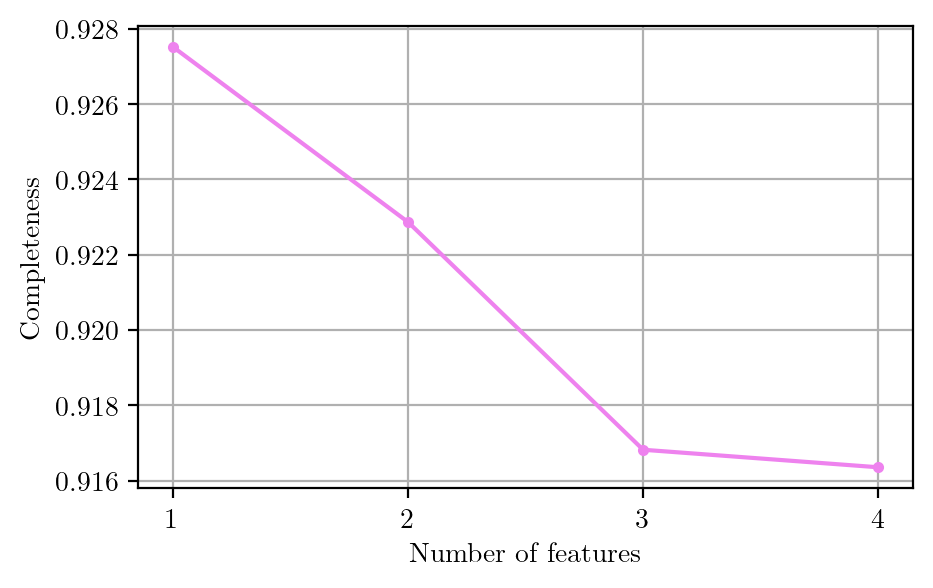

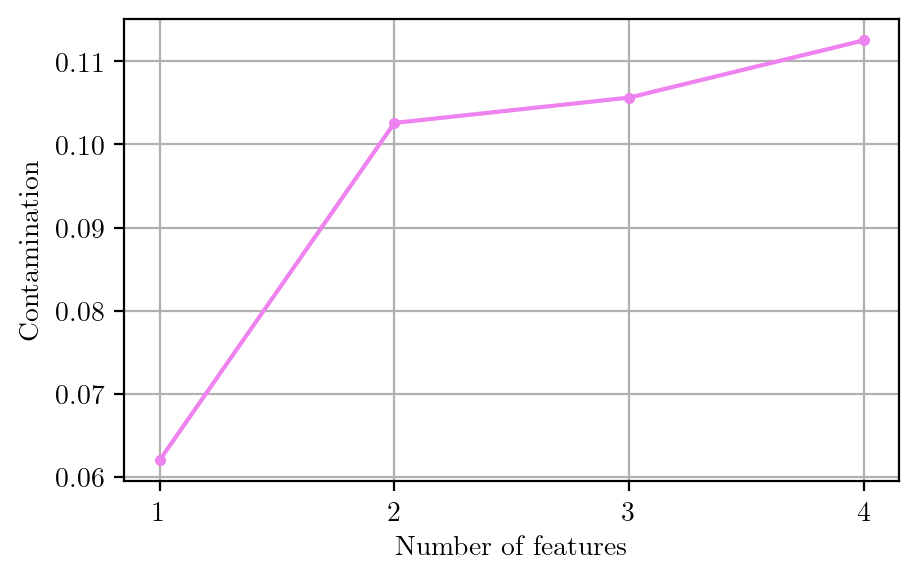

In [11]:
feat = np.linspace(1,4,4)
lab_prob = []
lab_pred = []

for x in feat:
    
    gnb = GaussianNB(priors=None)
    gnb.fit(X_train[:,:int(x)],lab_train)
    
    pred_labels = gnb.predict(X_test[:, :int(x)])
    pred_probs = gnb.predict_proba(X_test[:, :int(x)])[:, 1]
    
    lab_pred.append(pred_labels)
    lab_prob.append(pred_probs)

completeness, contamination = completeness_contamination(lab_pred, lab_test)
print(f'Gaussian Naive Bayes \nCompleteness = {completeness} \nContamination = {contamination}')

plt.figure(figsize=(5,3))
plt.plot(feat, completeness, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Completeness')
plt.xticks(feat)
plt.grid()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(feat, contamination, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Contamination')
plt.xticks(feat)
plt.grid()
plt.show()

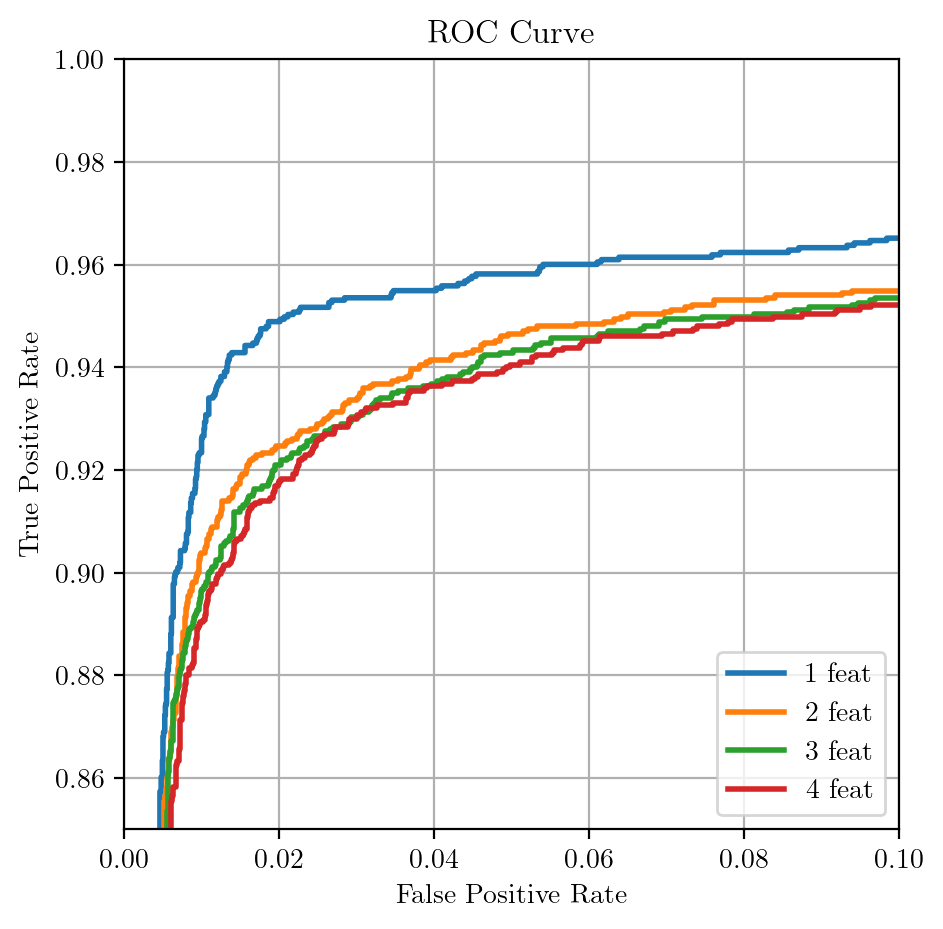

In [12]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob[int(i-1)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{int(i)} feat')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The first feature is the most important one here (u-g)

In [14]:
accuracy_ug = accuracy_score(lab_test, lab_pred[0])
print(f"Accuracy of gauss naive considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred[-1])
print(f"Accuracy gauss naive considering all the features: {accuracy:.4f}")

Accuracy of gauss naive considering only u-g feature: 0.9808
Accuracy gauss naive considering all the features: 0.9713


Use the result from u-g component to compare true distribution to predicted ones

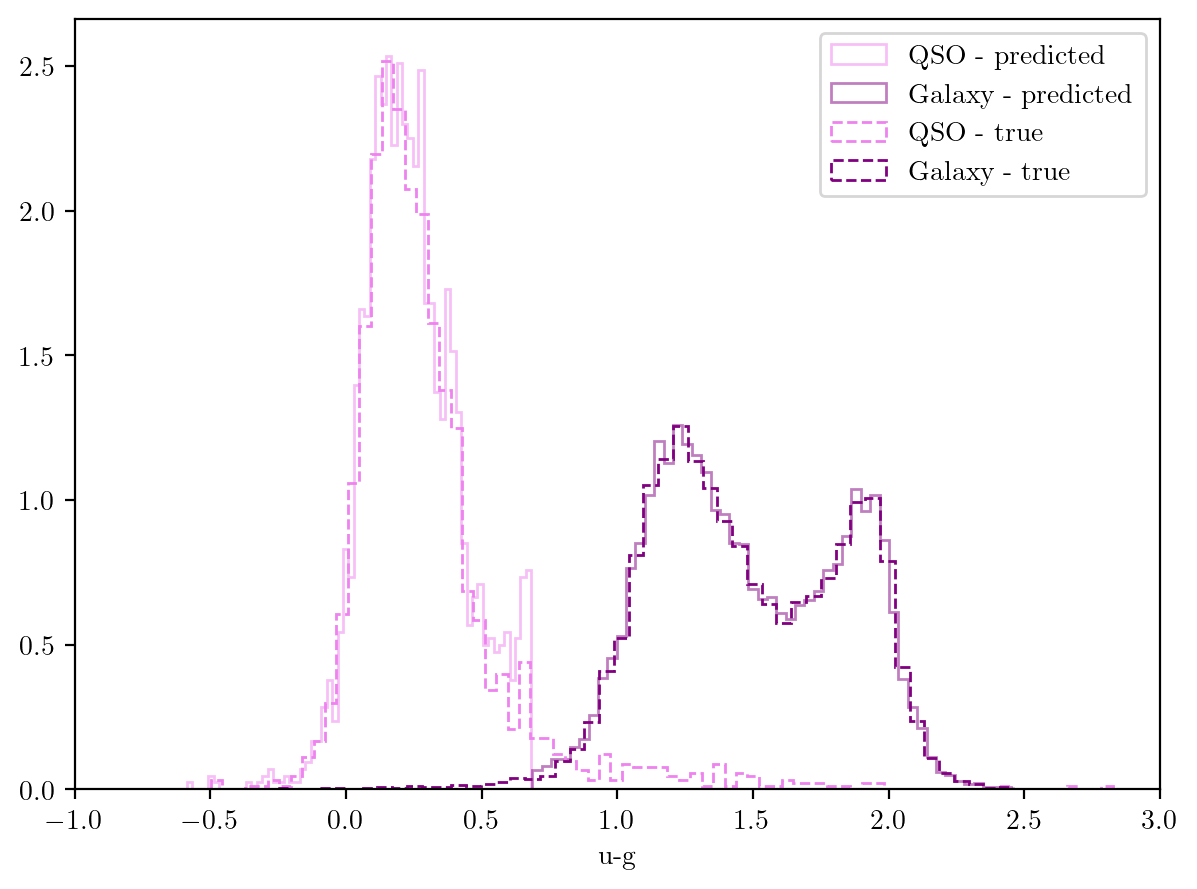

In [15]:
plt.figure(figsize=(7, 5))
plt.hist((X_test[:,0])[(lab_pred[0])==1], histtype='step', bins=100, label='QSO - predicted', color='violet', density=True, alpha=0.5)
plt.hist((X_test[:,0])[(lab_pred[0])==0], histtype='step', bins=100, label='Galaxy - predicted', color='purple', density=True, alpha=0.5)
plt.hist((X_test[:,0])[lab_test==1], histtype='step', linestyle='--', bins=100, label='QSO - true', color='violet', density=True)
plt.hist((X_test[:,0])[lab_test==0], histtype='step', linestyle='--', bins=100, label='Galaxy - true', color='purple', density=True)
plt.xlim(-1,3)
plt.legend(loc='upper right')
plt.xlabel('u-g')
plt.show()

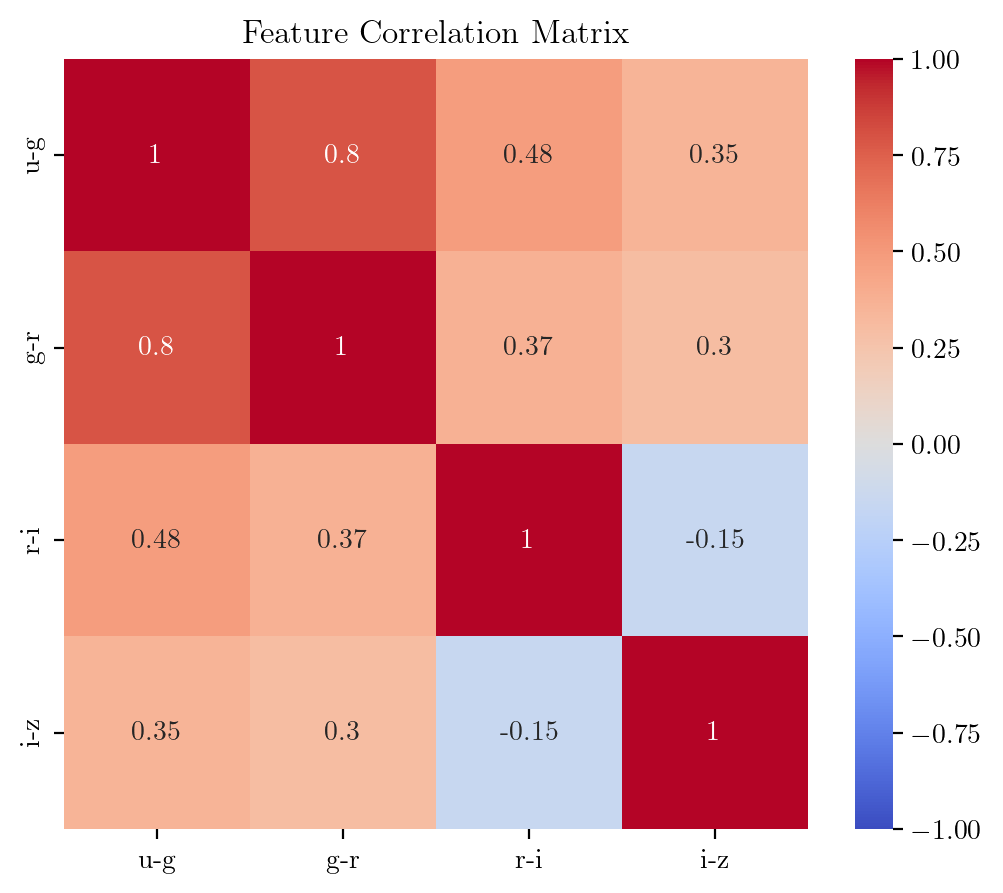

In [16]:
df = pd.DataFrame(X_train, columns=['u-g', 'g-r', 'r-i', 'i-z'])
corr_matrix = df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


Looking at the correlation matrix we can clearly see that the first and the second features are highly correlated, which is coherent with the result that we get from gaussian naive classifier that assumes all the features as independent. 
In fact the result is  more accurate using the first feature alone rather than using it in combination with the second 

### Linear and Quadr Discriminant Analysis

Linear DA 
Completeness = [0.92797398 0.92472119 0.92565056 0.92750929], Contamination = [0.06244131 0.05999055 0.0577105  0.05626478]
Quadratic DA 
Completeness = [0.92750929 0.93076208 0.92750929 0.92936803], Contamination = [0.06203008 0.06094702 0.06026365 0.06015038]


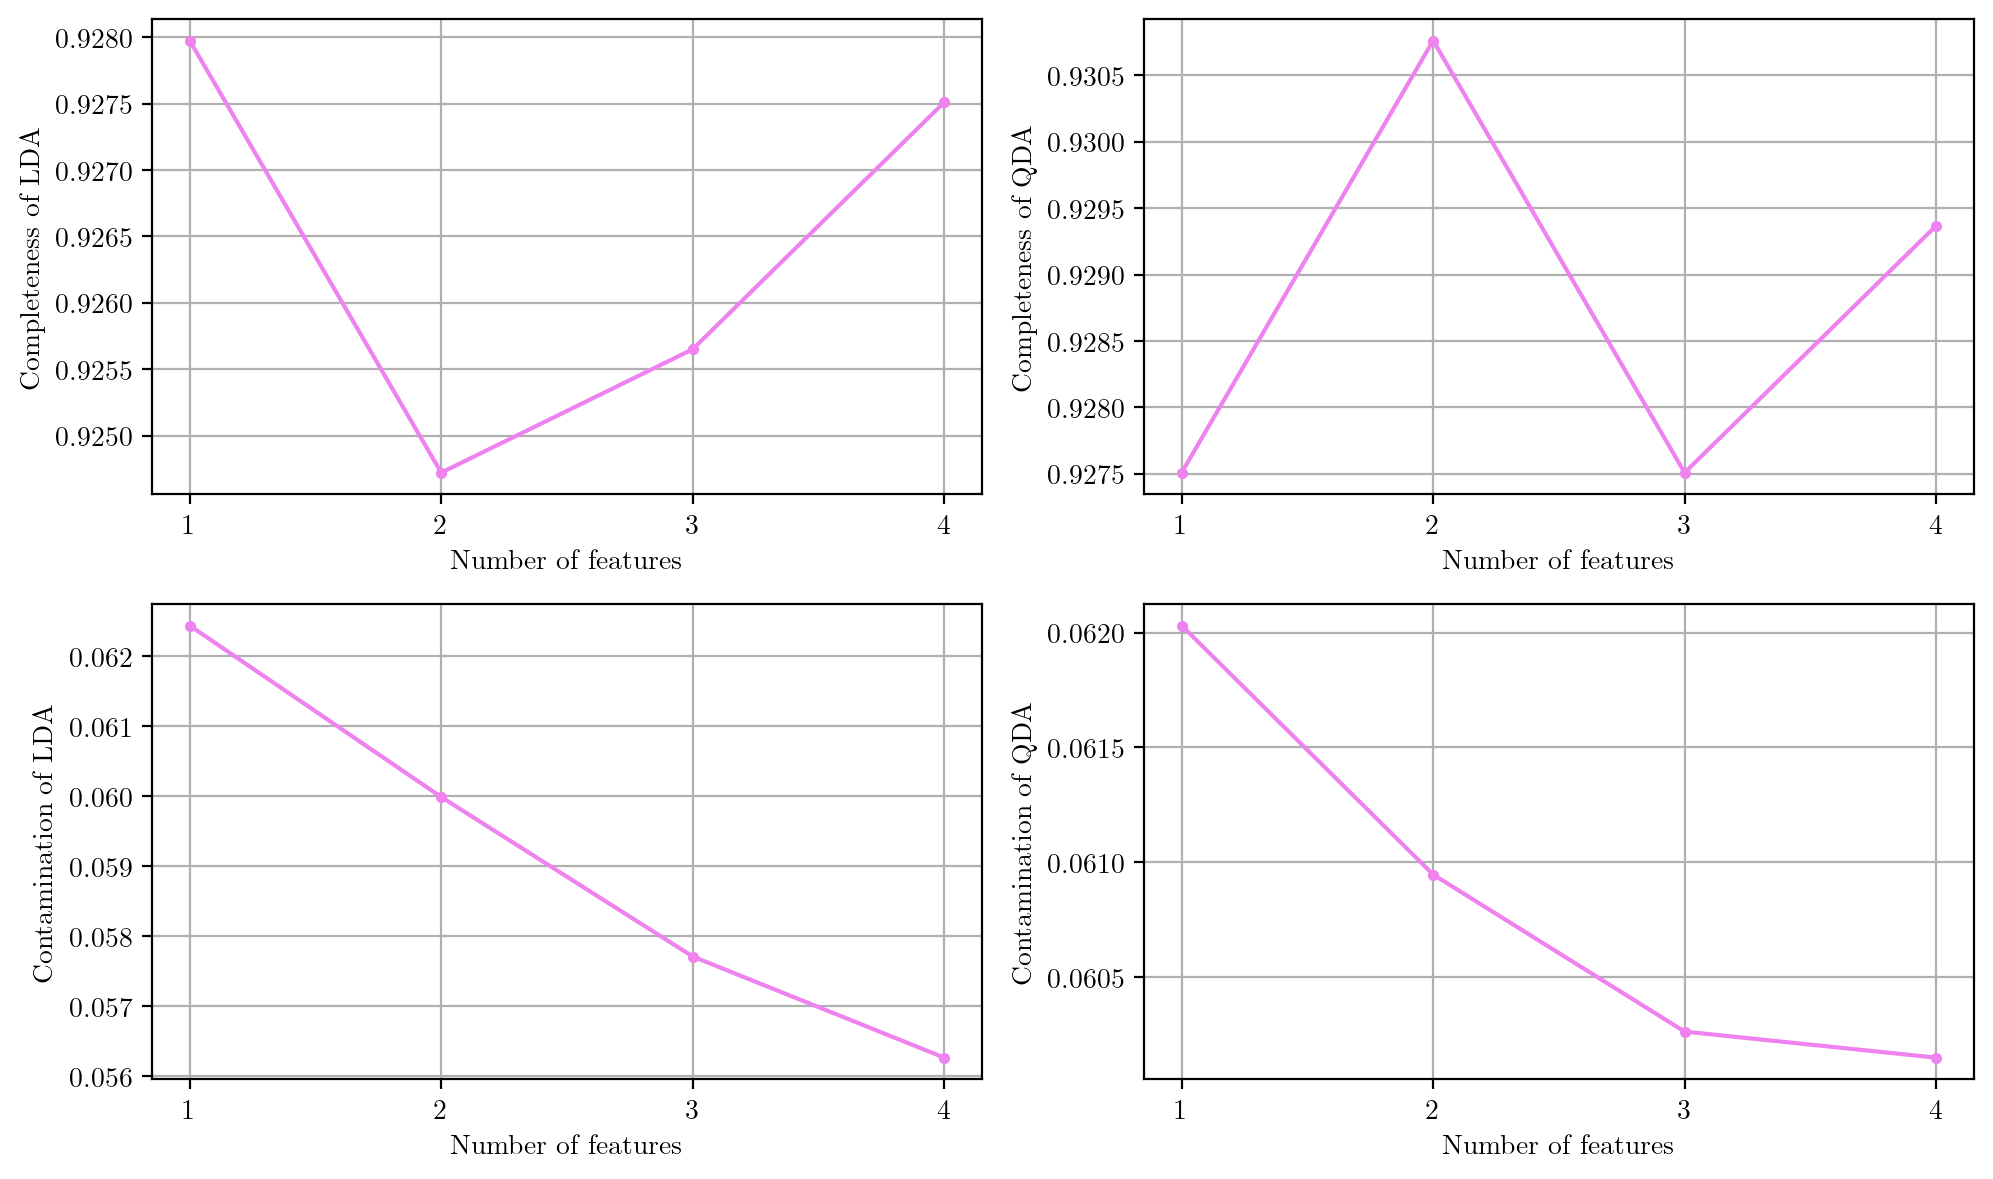

In [42]:
lab_prob_l = []
lab_pred_l = []
lab_prob_q = []
lab_pred_q = []

for x in feat:
    
    lda = LDA()
    lda.fit(X_train[:,:int(x)],lab_train)
    
    lab_pred_l.append(lda.predict(X_test[:, :int(x)]))
    lab_prob_l.append(lda.predict_proba(X_test[:, :int(x)])[:, 1])

    qda = QDA()
    qda.fit(X_train[:,:int(x)],lab_train)
    
    lab_pred_q.append(qda.predict(X_test[:, :int(x)]))
    lab_prob_q.append(qda.predict_proba(X_test[:, :int(x)])[:, 1])
    

completeness_l, contamination_l = completeness_contamination(lab_pred_l, lab_test)
print(f'Linear DA \nCompleteness = {completeness_l}, Contamination = {contamination_l}')


completeness_q, contamination_q = completeness_contamination(lab_pred_q, lab_test)
print(f'Quadratic DA \nCompleteness = {completeness_q}, Contamination = {contamination_q}')

plt.figure(figsize=(10, 6))


plt.subplot(2, 2, 1)
plt.plot(feat, completeness_l, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Completeness of LDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 2)
plt.plot(feat, completeness_q, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Completeness of QDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 3)
plt.plot(feat, contamination_l, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Contamination of LDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 4)
plt.plot(feat, contamination_q, marker='.', color='violet')
plt.xlabel('Number of features')
plt.ylabel('Contamination of QDA')
plt.grid()
plt.xticks(feat)

plt.tight_layout()
plt.show()

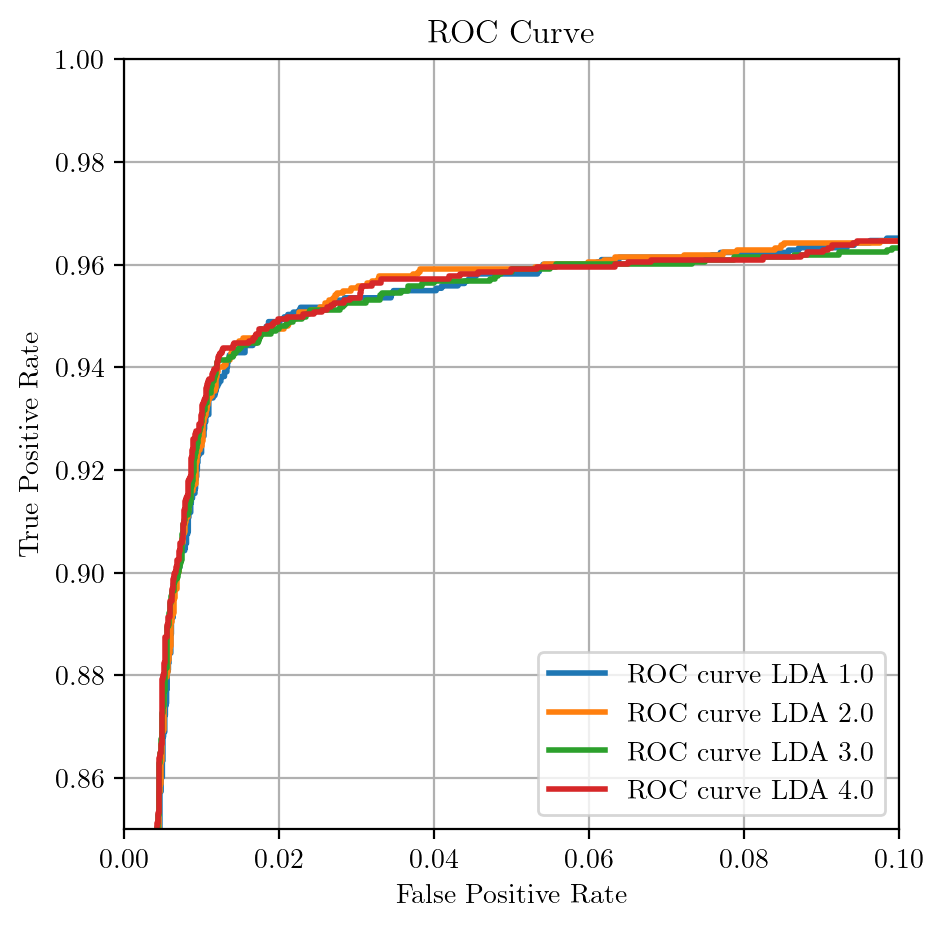

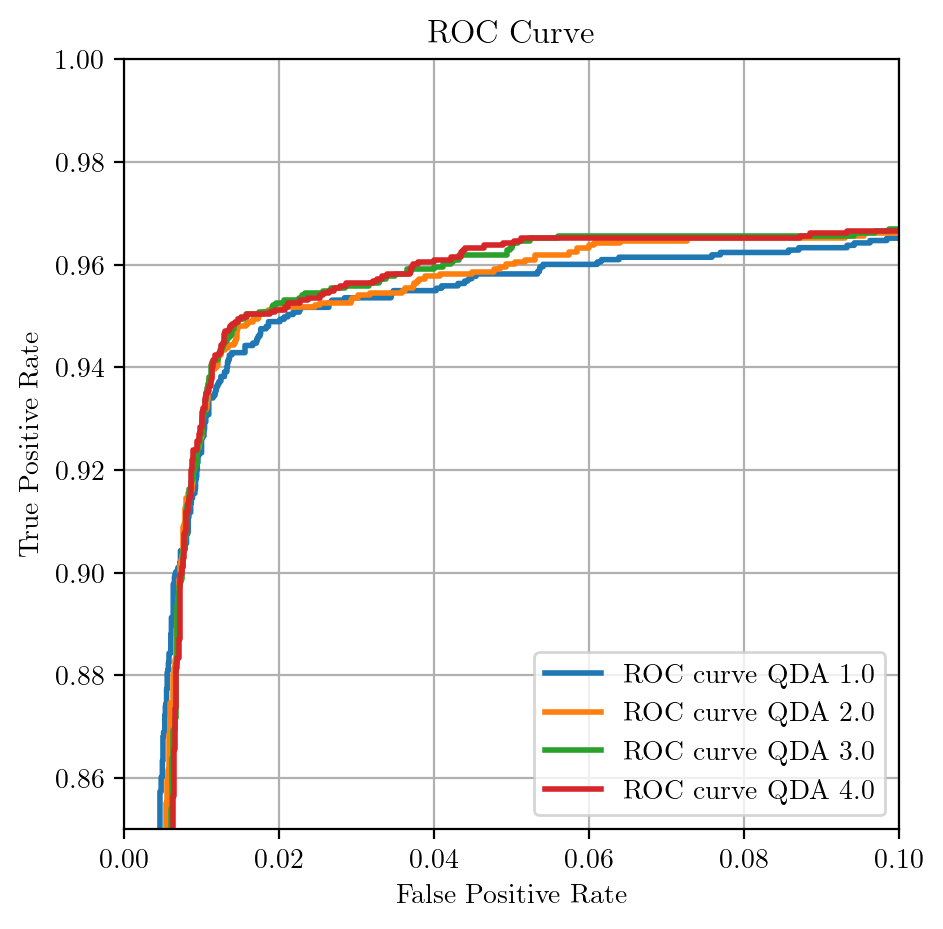

In [18]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob_l[int(i)-1])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve LDA {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob_q[int(i)-1])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve QDA {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [19]:
accuracy_ug = accuracy_score(lab_test, lab_pred_l[0])
print(f"Accuracy of LDA considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_l[3])
print(f"Accuracy of LDA considering all the features: {accuracy:.4f}")

Accuracy of LDA considering only u-g feature: 0.9808
Accuracy of LDA considering all the features: 0.9817


In [20]:
accuracy_ug = accuracy_score(lab_test, lab_pred_q[0])
print(f"Accuracy of QDA considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_q[3])
print(f"Accuracy of QDA considering all the features: {accuracy:.4f}")

Accuracy of QDA considering only u-g feature: 0.9808
Accuracy of QDA considering all the features: 0.9813


### GMM

GMM with 1 component 
Completeness = [0.92750929 0.93076208 0.92750929 0.92936803] 
Contamination = [0.06203008 0.06094702 0.06026365 0.06015038]

GMM with 5 components 
Completeness = [0.93355019 0.92750929 0.92843866 0.93076208] 
Contamination = [0.07248384 0.05223172 0.03757225 0.0480038 ]


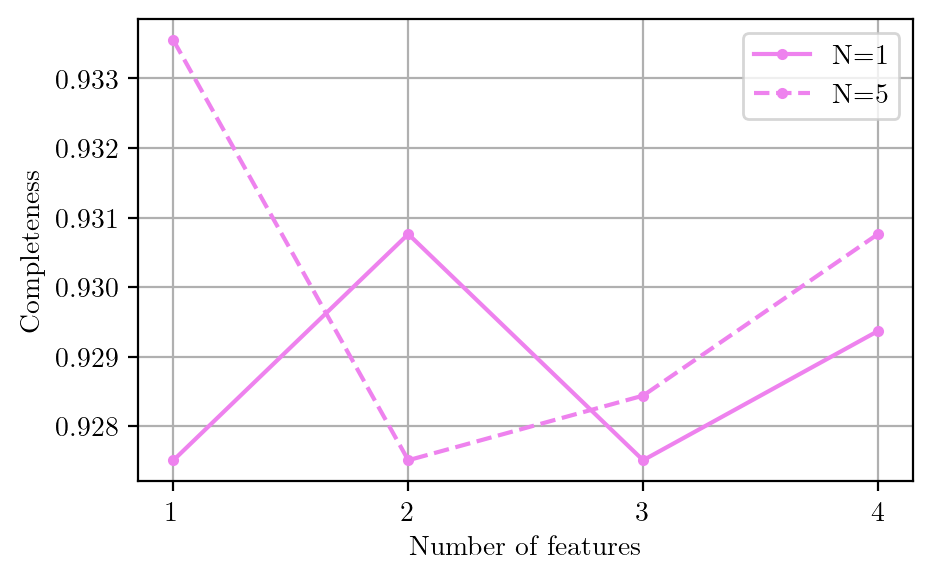

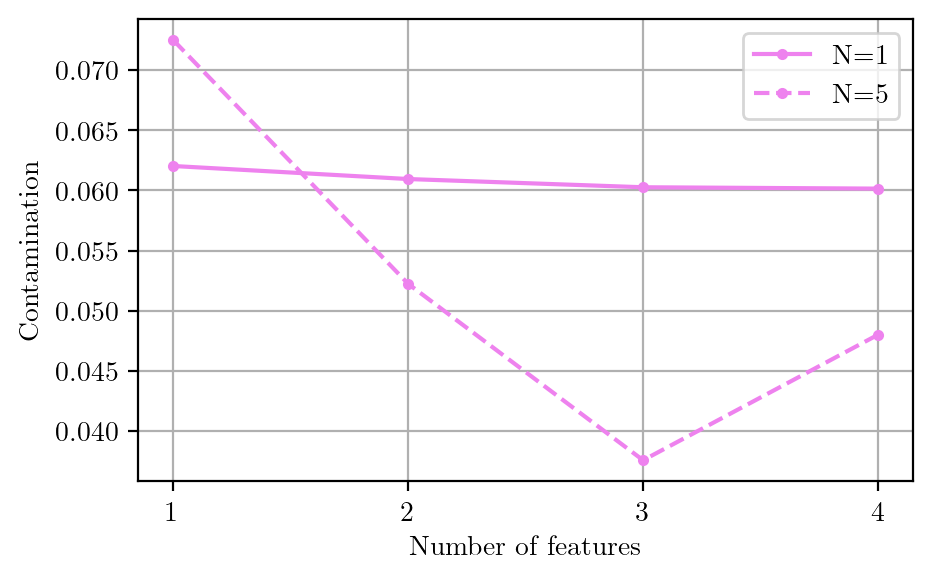

In [43]:
lab_pred_gmm = []
lab_prob_gmm = []
clusters = [1,5]

for c in clusters:
    
    for x in feat:
        
        gmm = GMMBayes(c, covariance_type='full')
        gmm.fit(X_train[:, :int(x)], lab_train)
        
        pred_labels = gmm.predict(X_test[:, :int(x)])
        pred_probs = gmm.predict_proba(X_test[:, :int(x)])[:, 1]
        
        lab_pred_gmm.append(pred_labels)
        lab_prob_gmm.append(pred_probs)



completeness, contamination = completeness_contamination(lab_pred_gmm, lab_test)
print(f'GMM with 1 component \nCompleteness = {completeness[:4]} \nContamination = {contamination[:4]}\n')
print(f'GMM with 5 components \nCompleteness = {completeness[4:]} \nContamination = {contamination[4:]}')

plt.figure(figsize=(5,3))
plt.plot(feat, completeness[:4], marker='.', color='violet', label='N=1')
plt.plot(feat, completeness[4:], marker='.', linestyle='--', color='violet', label='N=5')
plt.xlabel('Number of features')
plt.ylabel('Completeness')
plt.grid()
plt.legend()
plt.xticks(feat)
plt.show()

plt.figure(figsize=(5,3))
plt.plot(feat, contamination[:4], marker='.', color='violet', label='N=1')
plt.plot(feat, contamination[4:], marker='.', linestyle='--', color='violet', label='N=5')
plt.xlabel('Number of features')
plt.ylabel('Contamination')
plt.grid()
plt.legend()
plt.xticks(feat)
plt.show()

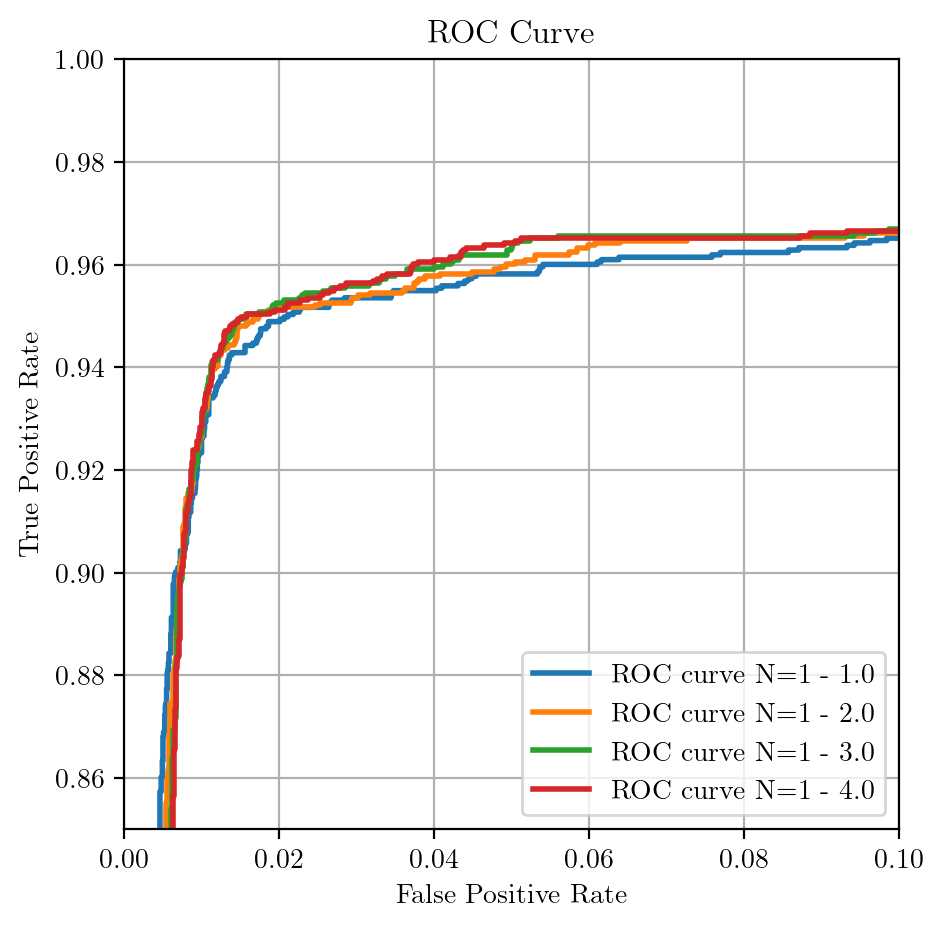

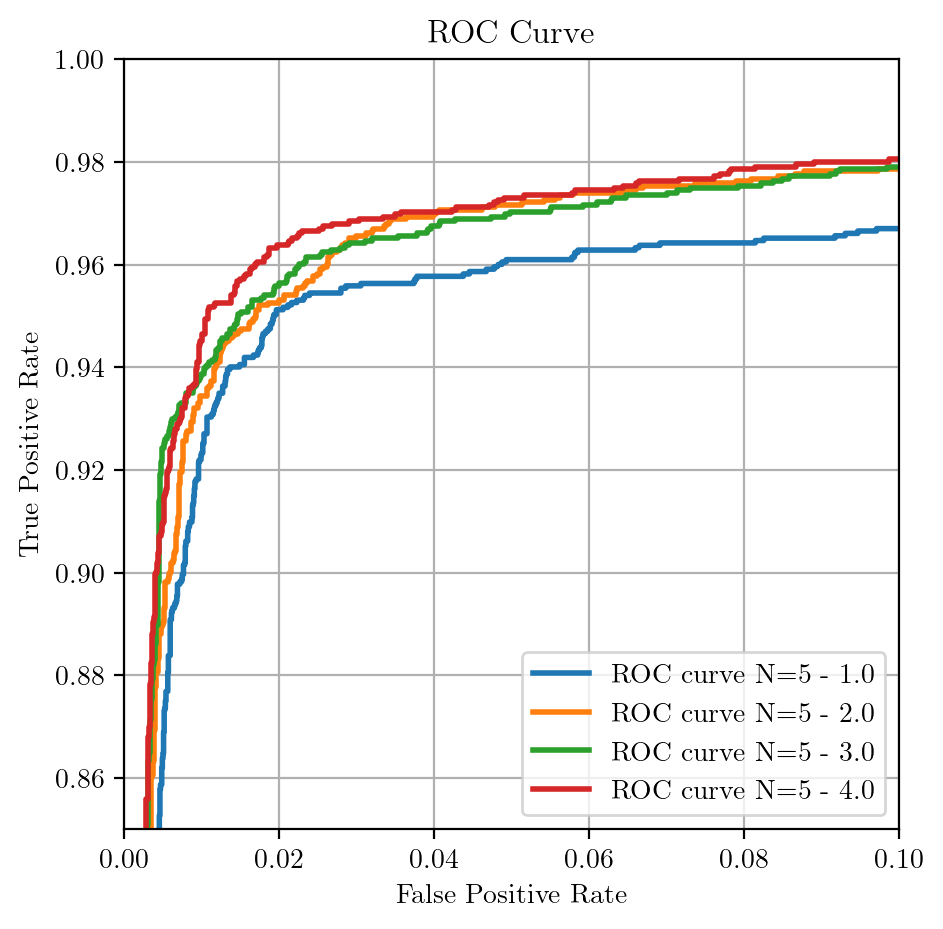

In [26]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr_1, tpr_1, _ = roc_curve(lab_test, lab_prob_gmm[int(i)-1])  
    plt.plot(fpr_1, tpr_1, lw=2, label=f'ROC curve N=1 - {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(5, 5))

for i in feat:
    fpr_5, tpr_5, _ = roc_curve(lab_test, lab_prob_gmm[int(i)+3])
    plt.plot(fpr_5, tpr_5, lw=2, label=f'ROC curve N=5 - {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [27]:
accuracy_ug = accuracy_score(lab_test, lab_pred_gmm[0])
print(f"Accuracy of GMM (N=1) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_gmm[3])
print(f"Accuracy of GMM (N=1) considering all the features: {accuracy:.4f}")

Accuracy of GMM (N=1) considering only u-g feature: 0.9808
Accuracy of GMM (N=1) considering all the features: 0.9813


In [28]:
accuracy_ug = accuracy_score(lab_test, lab_pred_gmm[4])
print(f"Accuracy of GMM (N=5) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_gmm[7])
print(f"Accuracy of GMM (N=5) considering all the features: {accuracy:.4f}")

Accuracy of GMM (N=5) considering only u-g feature: 0.9802
Accuracy of GMM (N=5) considering all the features: 0.9831


## K nearest neigh with cross validation on number of neighbors

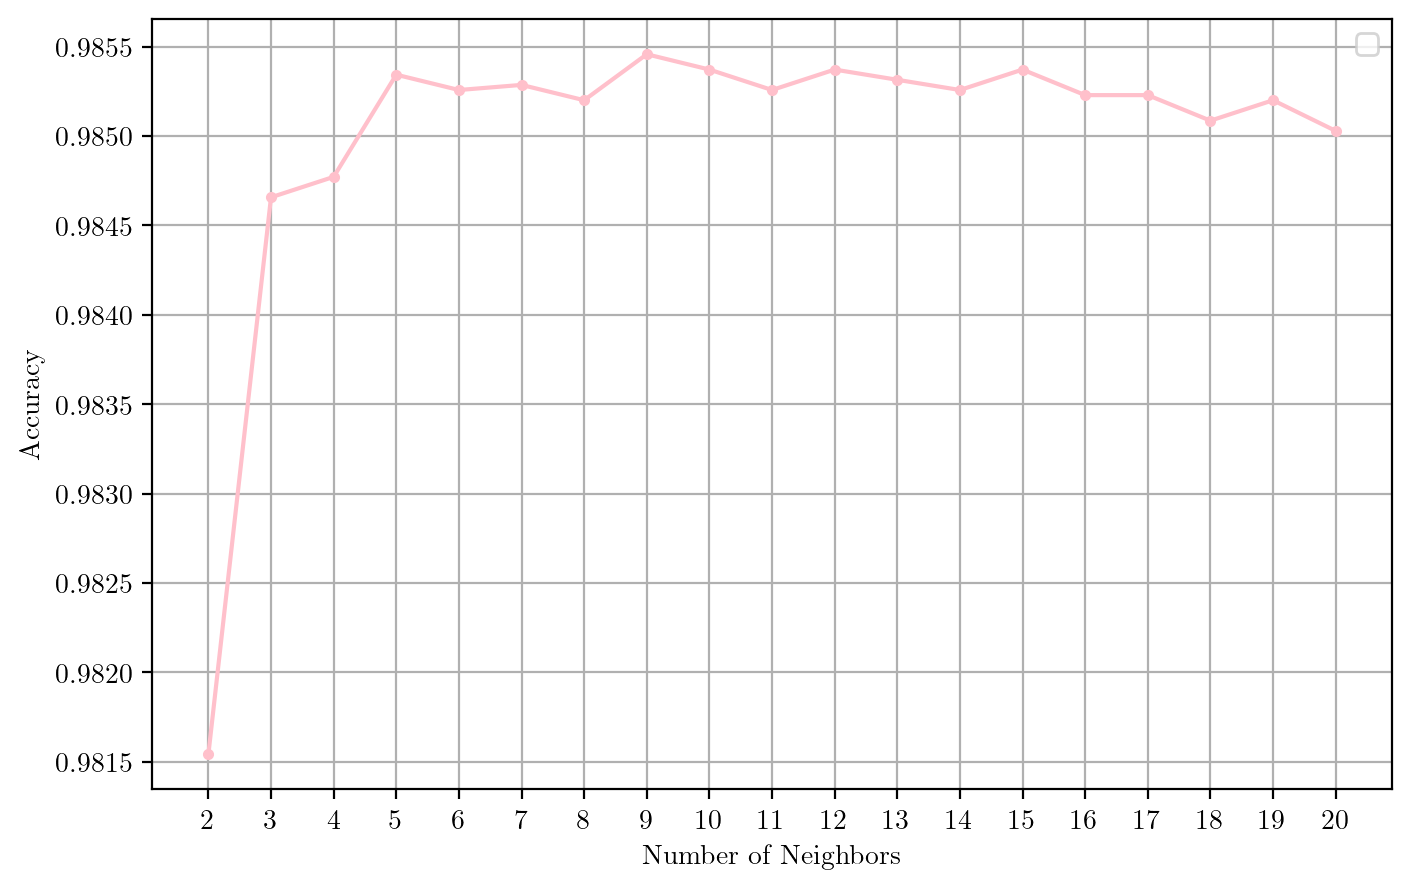

Best number of neighbors: 9 with accuracy: 0.9854571428571429
KNN with N=9 
Completeness = [0.92239777 0.92193309 0.93447955 0.94052045] 
Contamination = [0.05655894 0.05207836 0.03871893 0.03527169]


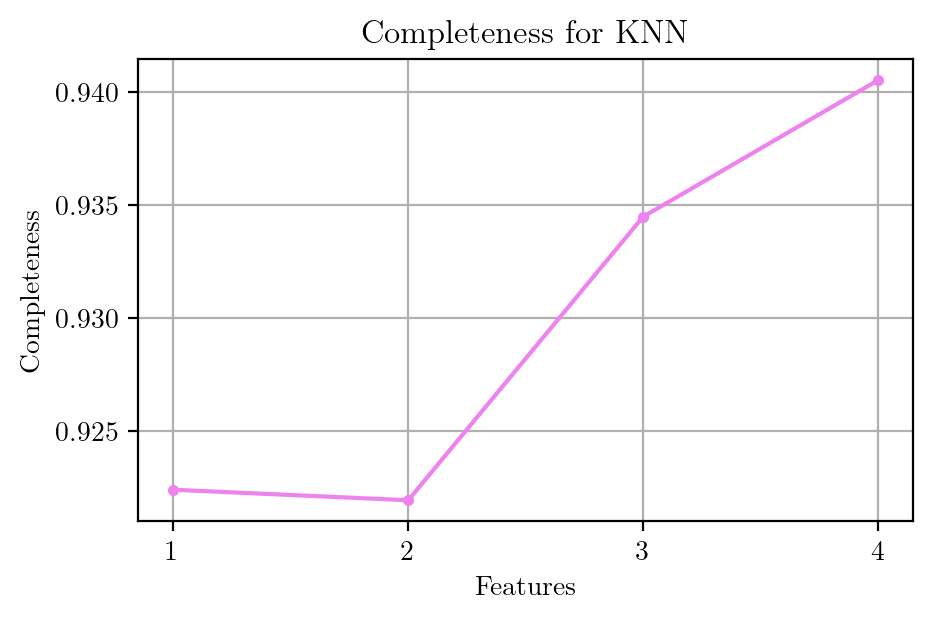

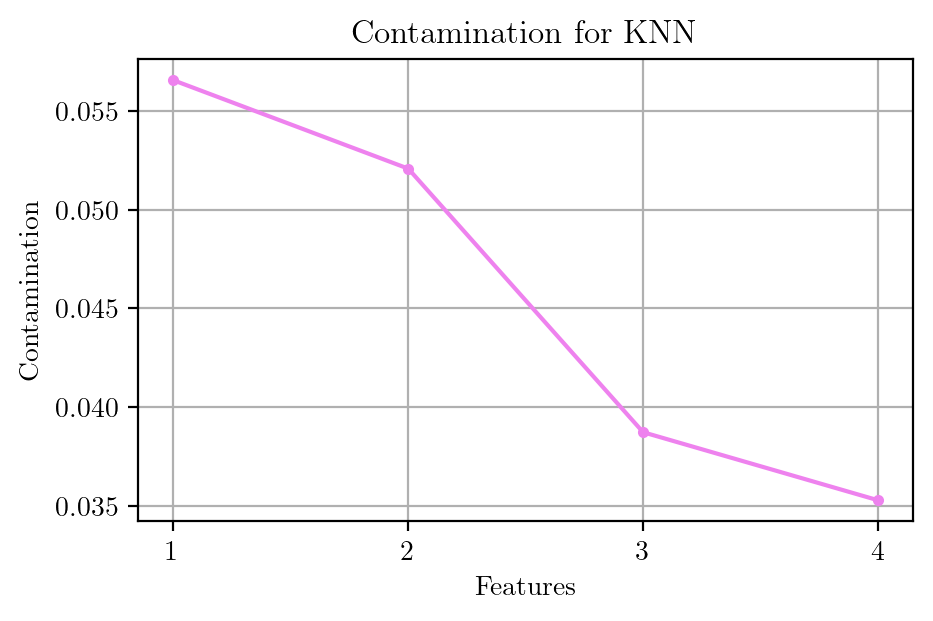

In [55]:
param_grid = {
    'n_neighbors': range(2, 21)  
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True) 

grid_search.fit(X_train, lab_train)

train_scores = grid_search.cv_results_['mean_train_score']
val_scores = grid_search.cv_results_['mean_test_score']
neighbors = grid_search.cv_results_['param_n_neighbors'].data

plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), val_scores, marker='.', color='pink')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(2,21))
plt.grid()
plt.show()

best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f'Best number of neighbors: {best_k} with accuracy: {best_score}')
knn_best = KNeighborsClassifier(n_neighbors=best_k)

lab_pred_kn = []
lab_prob_kn = []

for x in feat:
        knn_best.fit(X_train[:, :int(x)],lab_train)
       
        pred_labels = knn_best.predict(X_test[:, :int(x)])
        pred_probs = knn_best.predict_proba(X_test[:, :int(x)])[:, 1]
        
        lab_pred_kn.append(pred_labels)
        lab_prob_kn.append(pred_probs)


completeness, contamination = completeness_contamination(lab_pred_kn, lab_test)
print(f'KNN with N={best_k} \nCompleteness = {completeness} \nContamination = {contamination}')

plt.figure(figsize=(5, 3))
plt.plot(feat, completeness, marker='.', color='violet')
plt.xlabel('Features')
plt.ylabel('Completeness')
plt.grid()
plt.title('Completeness for KNN')
plt.xticks(feat)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(feat, contamination, marker='.', color='violet')
plt.xlabel('Features')
plt.ylabel('Contamination')
plt.grid()
plt.title('Contamination for KNN')
plt.xticks(feat)
plt.show()


In [56]:
accuracy_ug = accuracy_score(lab_test, lab_pred_kn[0])
print(f"Accuracy of KNN (N={best_k}) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_kn[3])
print(f"Accuracy of KNN (N={best_k}) considering all the features: {accuracy:.4f}")

Accuracy of KNN (N=9) considering only u-g feature: 0.9809
Accuracy of KNN (N=9) considering all the features: 0.9865


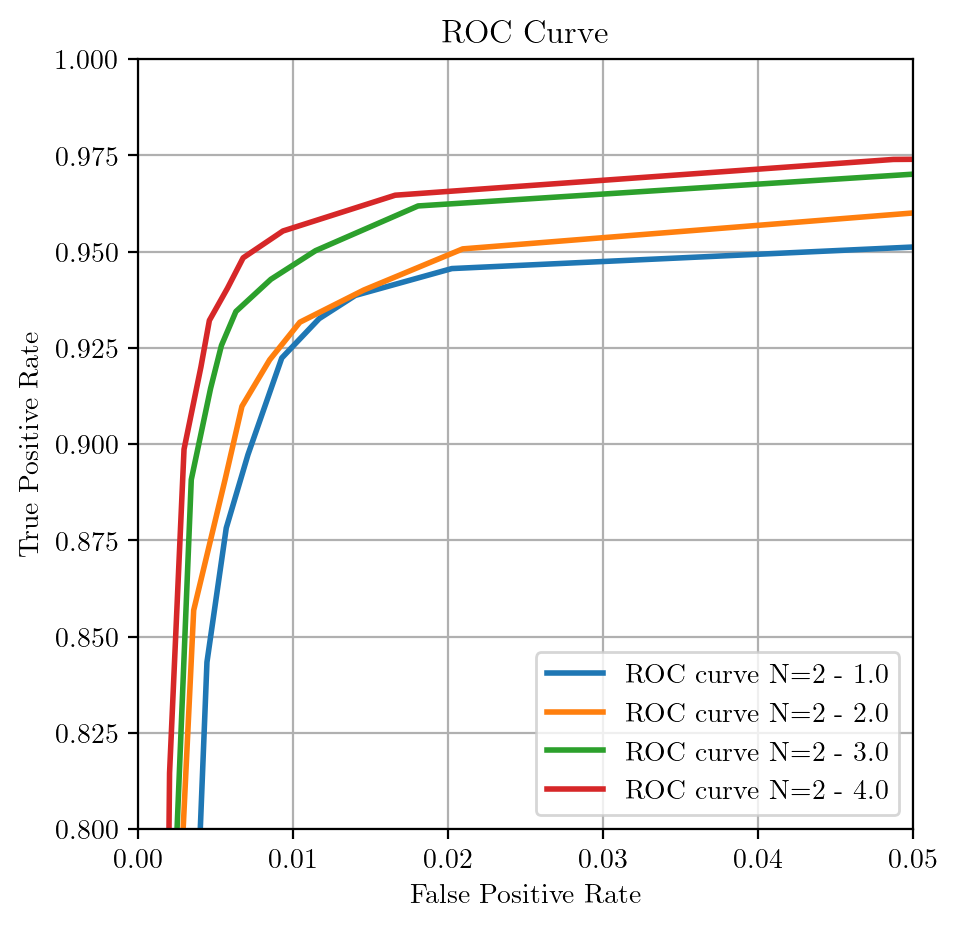

In [57]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob_kn[int(i)-1])  
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve N=2 - {i}')

plt.xlim([0.0, 0.05])
plt.ylim([0.8, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()